### **Applying LOST to segment the first video frame**

For implementing LOST: https://arxiv.org/pdf/2109.14279.pdf, we adapted the code of the paper, which is given on the following GitHub page: https://github.com/valeoai/LOST.

First we are going to apply LOST on an example image from the Davis2017 dataset.

Then, to improve the mask, we are going to apply the CRF processing step from the paper: https://arxiv.org/pdf/1210.5644.pdf, by adapting the following GitHub code: https://github.com/lucasb-eyer/pydensecrf.

In [ ]:
!git clone https://github.com/valeoai/LOST

Cloning into 'LOST'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 73 (delta 28), reused 46 (delta 11), pack-reused 0
Unpacking objects: 100% (73/73), done.


In [ ]:
!git clone https://github.com/facebookresearch/dino.git

Cloning into 'dino'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 168 (delta 88), reused 77 (delta 77), pack-reused 64
Receiving objects: 100% (168/168), 24.45 MiB | 35.81 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-h_xsyli8
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-h_xsyli8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2778818 sha256=9af4d935569cd2459e2f0678d1a45a9e40df8aa12c333b44fbef306e51865616
  Stored in directory: /tmp/pip-ephem-wheel-cache-4hneakud/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf


In [ ]:
# Access to dataset through Drive
import os
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive/


In [ ]:
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

Size of the example image :  (480, 854, 3)


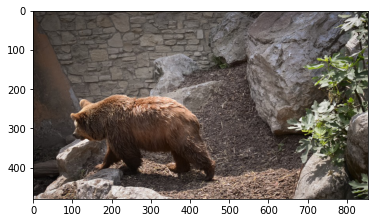

In [ ]:
# Example
# First image in the folder 'bear'
eg_image_path = '/content/drive/MyDrive/STCN/DAVIS/2017/trainval/JPEGImages/480p/bear/00000.jpg'
eg_image = Image.open(eg_image_path)
eg_image = np.array(eg_image)
eg_image_size = eg_image.shape
print('Size of the example image : ', eg_image_size)    # (480, 854, 3)
plt.imshow(eg_image)

In [ ]:
sys.path.insert(0, '/content/LOST')
sys.path.insert(1, '/content/dino')

In [ ]:
# Model
patch_size = 16
from networks import get_model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = get_model("vit_base", patch_size = patch_size, resnet_dilate=0, device=device)

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Pretrained weights found at dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth and loaded with msg: <All keys matched successfully>


In [ ]:
# Image transformation
from torchvision import transforms as pth_transforms
transform = pth_transforms.Compose(
    [
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
img = eg_image
img = transform(img)
init_image_size = img.shape    # [3, 480, 854]
im_name = '00000'

# Padding the image with zeros to fit multiple of patch-size
size_im = (
    img.shape[0],
    int(np.ceil(img.shape[1] / patch_size) * patch_size),
    int(np.ceil(img.shape[2] / patch_size) * patch_size),
)
paded = torch.zeros(size_im)
paded[:, : img.shape[1], : img.shape[2]] = img
img = paded

# Move to gpu
# img = img.cuda(non_blocking=True)
# Size for transformers
w_featmap = img.shape[-2] // patch_size    # 30
h_featmap = img.shape[-1] // patch_size    # 54

In [ ]:
which_features = "k"    # possible choices : "q", "k", "v"

with torch.no_grad():
    # Store the outputs of qkv layer from the last attention layer
    feat_out = {}
    def hook_fn_forward_qkv(module, input, output):
        feat_out["qkv"] = output

    model._modules["blocks"][-1]._modules["attn"]._modules["qkv"].register_forward_hook(hook_fn_forward_qkv)

    # Forward pass in the model
    attentions = model.get_last_selfattention(img[None, :, :, :])

    # Scaling factor
    scales = [patch_size, patch_size]

    # Dimensions
    nb_im = attentions.shape[0]  # Batch size
    nh = attentions.shape[1]  # Number of heads
    nb_tokens = attentions.shape[2]  # Number of tokens

    # Extract the qkv features of the last attention layer
    qkv = (
        feat_out["qkv"]
        .reshape(nb_im, nb_tokens, 3, nh, -1 // nh)
        .permute(2, 0, 3, 1, 4)
    )
    q, k, v = qkv[0], qkv[1], qkv[2]
    k = k.transpose(1, 2).reshape(nb_im, nb_tokens, -1)
    q = q.transpose(1, 2).reshape(nb_im, nb_tokens, -1)
    v = v.transpose(1, 2).reshape(nb_im, nb_tokens, -1)

    # Modality selection
    if which_features == "k":     # keys of the patches
        feats = k[:, 1:, :]       # tensor [1, 1620, 768]
    elif which_features == "q":
        feats = q[:, 1:, :]
    elif which_features == "v":
        feats = v[:, 1:, :]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
# Slightly modified LOST
# Instead of returning the bounding box predictions, it returns the mask
def modified_lost(feats, dims, scales, init_image_size, k_patches=100):
    """
    Inputs
        feats: the pixel/patche features of an image
        dims: dimension of the map from which the features are used
        scales: from image to map scale
        init_image_size: size of the image
        k_patches: number of k patches retrieved that are compared to the seed at seed expansion
    Outputs
        M: mask
        seed: selected patch corresponding to an object
    """
    # Compute the similarity
    A = (feats @ feats.transpose(1, 2)).squeeze()

    # Compute the inverse degree centrality measure per patch
    sorted_patches, scores = patch_scoring(A)

    # Select the initial seed
    seed = sorted_patches[0]

    # Seed expansion
    potentials = sorted_patches[:k_patches]
    similars = potentials[A[seed, potentials] > 0.0]
    M = torch.sum(A[similars, :], dim=0)

    return M, seed

In [ ]:
from object_discovery import patch_scoring
k_patches = 100    # Number of patches with the lowest degree considered

# Apply modified LOST
M, seed = modified_lost(
    feats,
    [w_featmap, h_featmap],
    scales,
    init_image_size,
    k_patches=k_patches,
)

# Sizes of the output values :
# M : tensor [1620]
# seed : tensor(767) = scalar

Now we are going to extract the mask.

In [ ]:
import scipy

# Reshape M
correl = M.reshape(w_featmap, h_featmap).float()    # tensor [30, 54]

# Compute connected components
labeled_array, num_features = scipy.ndimage.label(correl.cpu().numpy() > 0.0)

# labeled_array : array (30, 54)
# num_features = 1

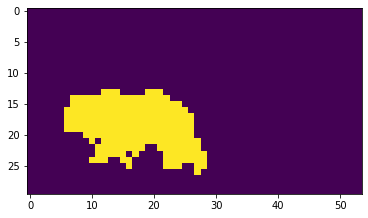

In [ ]:
# Plot mask
plt.imshow(labeled_array)

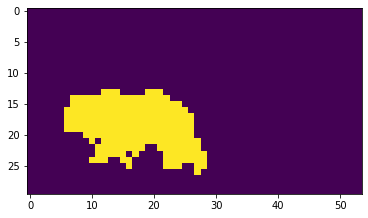

In [ ]:
# Find connected component corresponding to the initial seed
cc = labeled_array[np.unravel_index(seed.cpu().numpy(), (w_featmap, h_featmap))]  # cc = 1

# Plot mask corresponding to the connected component containing the seed
plt.imshow(labeled_array == cc)

Size of the resized mask :  (480, 854)


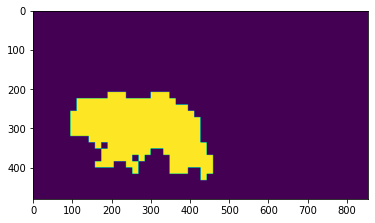

In [ ]:
# Compute mask containing the seed
mask = (labeled_array == cc)    # array (30, 54)

# Size of the example image not considering the channels
eg_image_size_2d = eg_image_size[:2]

from skimage.transform import resize
# Resize the mask to the size of the example image
resized_mask = resize(mask, eg_image_size_2d)
print('Size of the resized mask : ', resized_mask.shape)

# Plot resized mask
plt.imshow(resized_mask)

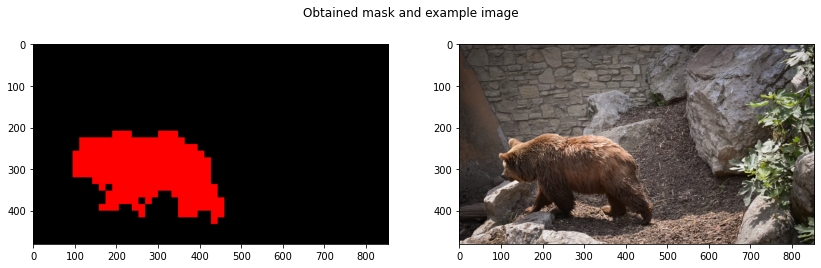

In [ ]:
# Colour the mask red
black_image = 0 * eg_image                 # array (480, 854, 3)
black_image[resized_mask == 1, 0] = 255
red_mask = black_image
red_mask = Image.fromarray(red_mask, 'RGB')
red_mask.save('/content/red_mask.png')

# Plot red mask and example image
figure, (ax1, ax2) = plt.subplots(1, 2)
figure.suptitle('Obtained mask and example image')
figure = plt.gcf()
figure.set_size_inches(14, 4)
ax1.imshow(red_mask)
ax2.imshow(eg_image)

### Now we are going to apply the CRF processing step.

In [ ]:
import itertools
import glob
import pydensecrf.densecrf as dcrf

In [ ]:
# Unary potential
# U[0, :, :] : channel of the background
# U[1, :, :] : channel of the object
U = np.ones((2, resized_mask.shape[0], resized_mask.shape[1]), dtype=np.float32)  # array (2, 480, 854)
U[0, :, :] = 10
U[1, resized_mask==1] = 100
U = U / U.sum(0, keepdims=True)    # Probability of the classes at different positions

d = dcrf.DenseCRF2D(854, 480, 2)  # Width, height, nlabels

U = - np.log(U)    # Minus log probability
U = U.reshape((2,-1)) # Needs to be flat
d.setUnaryEnergy(U)

In [ ]:
# This adds the color-independent term, features are the locations only
d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)

# This adds the color-dependent term, i.e. features are (x,y,r,g,b)
d.addPairwiseBilateral(sxy=(40, 40), srgb=(13, 13, 13), rgbim=np.array(eg_image),
                        compat=10,
                        kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)

Shape of the mask :  (480, 854)


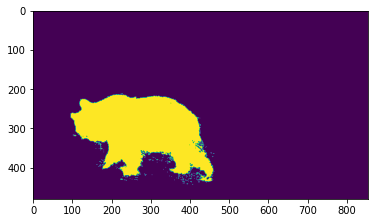

In [ ]:
Q = d.inference(10)

# Find out the most probable class for each pixel
MAP = np.argmax(Q, axis=0)

reshaped_MAP = MAP.reshape((480, 854))

print('Shape of the mask : ', reshaped_MAP.shape)
plt.imshow(reshaped_MAP)

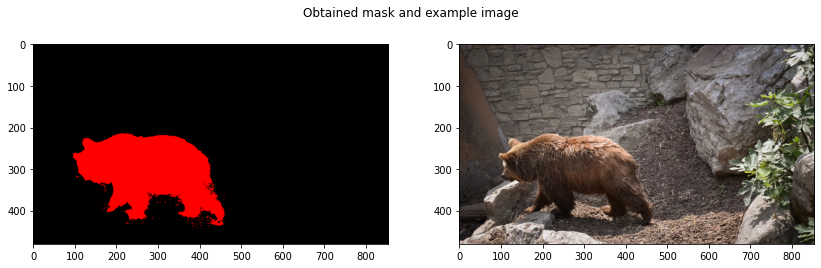

In [ ]:
# Colour the new mask red
black_mask = 0 * eg_image      # array (480, 854, 3)
black_mask[reshaped_MAP == 1, 0] = 255
new_mask = black_mask
new_mask = Image.fromarray(new_mask, 'RGB')
new_mask.save('/content/new_mask.png')

# Compare the obtained mask with the example image
figure, (ax1, ax2) = plt.subplots(1, 2)
figure.suptitle('Obtained mask and example image')
figure = plt.gcf()
figure.set_size_inches(14, 4)
ax1.imshow(new_mask)
ax2.imshow(eg_image)

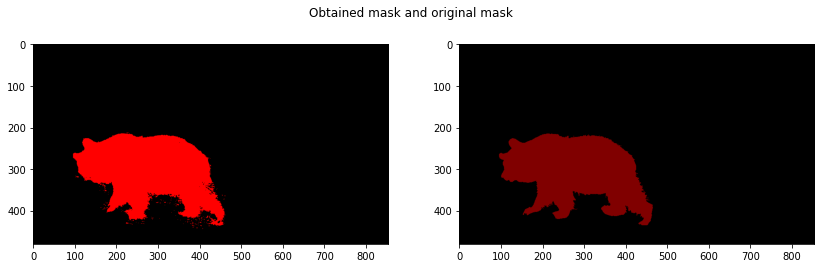

In [ ]:
# Compare the obtained mask with the original mask
original_mask_path = os.path.join('/content/drive/MyDrive/STCN/DAVIS/2017/trainval/Annotations/480p/bear/00000.png')
original_mask = Image.open(original_mask_path)
original_mask = original_mask.convert('RGB')

figure, (ax1, ax2) = plt.subplots(1, 2)
figure.suptitle('Obtained mask and original mask')
figure = plt.gcf()
figure.set_size_inches(14, 4)
ax1.imshow(new_mask)
ax2.imshow(original_mask)